# Iterative Patch Selection - Simple Example

In this notebook, we apply IPS to a subset of the MNIST dataset for illustration purposes. Images are resized to 500x500 and 25 patches of size 100x100 are extracted. We use a memory size of 5 patches.

IPS is applied in the eager loading setting, i.e. the full input batch is directly loaded onto the GPU. Furthermore, positional encoding is omitted here. For full control over all settings, we refer to the more complete Github repository.

In [1]:
import os
import random
import math
from matplotlib import pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet18

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [3]:
data_dir = '/files/'
img_size = 500
n_chan = 1
n_class = 10
patch_size = 100
patch_stride = 100
batch_size = 128
n_epoch = 10

M = 5 # Number of selected patches
I = 5 # Number of patches concatenated with memory buffer in each iteration
D = 512 # Feature dim

# Data preparation

We resize the MNIST images to 500x500 and create 25 non-overlapping patches of size 100x100. To reduce training time, a random subset of 10,000 training images will be used.

In [4]:
def patchify(img, patch_size, patch_stride):
    patches = img.unfold(
        1, patch_size, patch_stride
    ).unfold(
        2, patch_size, patch_stride
    ).permute(1, 2, 0, 3, 4)
    patches = patches.reshape(-1, *patches.shape[2:])
    return patches

transform=torchvision.transforms.Compose([
  torchvision.transforms.Resize(img_size),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Lambda(lambda x: patchify(x, patch_size, patch_stride))
])

subset_size = 10000
train_set = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transform)
subset_indices = torch.randperm(len(train_set))[:subset_size]
train_set = torch.utils.data.Subset(train_set, subset_indices)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Cross-Attention Transformer

In [5]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, temperature, attn_dropout=0.1):
    super().__init__()
    self.temperature = temperature
    self.dropout = nn.Dropout(attn_dropout)

  def compute_attn(self, q, k):
    attn = torch.matmul(q / self.temperature, k.transpose(2, 3))
    attn = self.dropout(torch.softmax(attn, dim=-1))
    return attn

  def forward(self, q, k, v):
    attn = self.compute_attn(q, k)
    output = torch.matmul(attn, v)
    return output

class MultiHeadCrossAttention(nn.Module):
  def __init__(self, n_token, H, D, D_k, D_v, attn_dropout, dropout):
    super().__init__()
    self.n_token = n_token
    self.H = H
    self.D_k = D_k
    self.D_v = D_v

    self.q = nn.Parameter(torch.empty((1, n_token, D)))
    q_init_val = math.sqrt(1 / D_k)
    nn.init.uniform_(self.q, a=-q_init_val, b=q_init_val)

    self.q_w = nn.Linear(D, H * D_k, bias=False)
    self.k_w = nn.Linear(D, H * D_k, bias=False)
    self.v_w = nn.Linear(D, H * D_v, bias=False)
    self.fc = nn.Linear(H * D_v, D, bias=False)

    self.attention = ScaledDotProductAttention(
        temperature=D_k ** 0.5,
        attn_dropout=attn_dropout
    )

    self.dropout = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(D, eps=1e-6)

  def get_attn(self, x):
    D_k, H, n_token = self.D_k, self.H, self.n_token
    B, len_seq = x.shape[:2]

    q = self.q_w(self.q).view(1, n_token, H, D_k)
    k = self.k_w(x).view(B, len_seq, H, D_k)

    q, k = q.transpose(1, 2), k.transpose(1, 2)

    attn = self.attention.compute_attn(q, k)
    return attn

  def forward(self, x):
    D_k, D_v, H, n_token = self.D_k, self.D_v, self.H, self.n_token
    B, len_seq = x.shape[:2]

    # project and separate heads
    q = self.q_w(self.q).view(1, n_token, H, D_k)
    k = self.k_w(x).view(B, len_seq, H, D_k)
    v = self.v_w(x).view(B, len_seq, H, D_v)

    # transpose for attention dot product: B x H x len_seq x D_k or D_v
    q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
    # cross-attention
    x = self.attention(q, k, v)

    # transpose again: B x n_token x H x D_v
    # concat heads: B x n_token x (H * D_v)
    x = x.transpose(1, 2).contiguous().view(B, n_token, -1)
    # combine heads
    x = self.dropout(self.fc(x))
    # residual connection + layernorm
    x += self.q
    x = self.layer_norm(x)
    return x

class MLP(nn.Module):
  def __init__(self, D, D_inner, dropout):
    super().__init__()
    self.w_1 = nn.Linear(D, D_inner)
    self.w_2 = nn.Linear(D_inner, D)
    self.layer_norm = nn.LayerNorm(D, eps=1e-6)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    residual = x
    x = self.w_2(torch.relu(self.w_1(x)))
    x = self.dropout(x)
    x += residual
    x = self.layer_norm(x)
    return x

class Transformer(nn.Module):
  def __init__(self, n_token=1, H=8, D=512, D_k=64, D_v=64, D_inner=2048, attn_dropout=0.1, dropout=0.1):
    super().__init__()
    self.crs_attn = MultiHeadCrossAttention(n_token, H, D, D_k, D_v, attn_dropout, dropout)
    self.mlp = MLP(D, D_inner, dropout)
  
  def get_scores(self, x):
    attn = self.crs_attn.get_attn(x)
    # Average scores over heads and tasks
    return attn.mean(dim=1).transpose(1, 2).mean(-1)

  def forward(self, x):
    return self.mlp(self.crs_attn(x))

# Iterative Patch Selection
Network that runs the full pipeline including patch encoder, IPS, patch aggregation module and classification head. We use a ResNet-18 trained from scratch as patch encoder in this example.

In [6]:
class IPSNet(nn.Module):
  def __init__(self, M, I, D):
    super().__init__()
    self.M = M
    self.I = I
    self.D = D

    self.patch_encoder = resnet18()
    self.patch_encoder.conv1 = nn.Conv2d(n_chan, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.patch_encoder.fc = nn.Identity() #just need features

    self.transf = Transformer()
    self.head = nn.Sequential(nn.Linear(D, n_class))
  
  def score_and_select(self, emb, M, idx):
    """Scores embeddings and selects the top-M embeddings"""
    # Obtain scores from transformer
    attn = self.transf.get_scores(emb) # (B, M+I)

    # Get indices of top-scoring patches
    top_idx = torch.topk(attn, M, dim=-1)[1] # (B, M)
    
    # Update memory buffers
    mem_emb = torch.gather(emb, 1, top_idx.unsqueeze(-1).expand(-1,-1,self.D))
    mem_idx = torch.gather(idx, 1, top_idx)

    return mem_emb, mem_idx

  # IPS runs in no-gradient mode
  @torch.no_grad()
  def ips(self, patches):
    """Iterative Patch Selection"""
    patch_shape = patches.shape
    B, N = patch_shape[:2]

    # Shortcut: IPS not required when memory is larger than total number of patches
    if M >= N:
      return patches
    
    # IPS runs in evaluation mode
    if self.training:
        self.patch_encoder.eval()
        self.transf.eval()

    # Init memory buffer
    init_patch = patches[:,:M]
    # Apply patch encoder
    mem_emb = self.patch_encoder(init_patch.reshape(-1, *patch_shape[2:]))
    mem_emb = mem_emb.view(B, M, -1)
    
    # Init memory indices in order to select patches at the end of IPS.
    idx = torch.arange(N, dtype=torch.int64, device=mem_emb.device).unsqueeze(0).expand(B, -1)
    mem_idx = idx[:,:M]

    # Apply IPS for `n_iter` iterations
    n_iter = math.ceil((N - M) / I)
    for i in range(n_iter):
        # Get next patches
        start_idx = i * I + M
        end_idx = min(start_idx + I, N)

        iter_patch = patches[:, start_idx:end_idx]
        iter_idx = idx[:, start_idx:end_idx]

        # Embed patches
        iter_emb = self.patch_encoder(iter_patch.reshape(-1, *patch_shape[2:]))
        iter_emb = iter_emb.view(B, -1, D)
        
        # Concatenate with memory buffer
        all_emb = torch.cat((mem_emb, iter_emb), dim=1)
        all_idx = torch.cat((mem_idx, iter_idx), dim=1)

        # Select Top-M patches according to cross-attention scores
        mem_emb, mem_idx = self.score_and_select(all_emb, M, all_idx)

    # Select patches
    n_dim_expand = len(patch_shape) - 2
    mem_patch = torch.gather(patches, 1, 
        mem_idx.view(B, -1, *(1,)*n_dim_expand).expand(-1, -1, *patch_shape[2:])
    )

    # Set components back to training mode
    # Although components of `self` that are relevant for IPS have been set to eval mode,
    # self is still in training mode at training time, i.e., we can use it here.
    if self.training:
        self.patch_encoder.train()
        self.transf.train()

    # Return selected patches
    return mem_patch, mem_idx

  def forward(self, mem_patch):
    """
    After M patches have been selected during IPS, encode and aggregate them.
    The aggregated embedding is input to a classification head.
    """
    patch_shape = mem_patch.shape
    B, M = patch_shape[:2]
    
    mem_emb = self.patch_encoder(mem_patch.reshape(-1, *patch_shape[2:]))
    mem_emb = mem_emb.view(B, M, -1)        

    image_emb = self.transf(mem_emb).squeeze(1)
    pred = self.head(image_emb)
    return pred


# Training loop

In [7]:
net = IPSNet(M, I, D).cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3, weight_decay=0.1)

for epoch in range(n_epoch):
  net.train()

  losses = []
  correct, total = 0, 0
  for data in train_loader:
    image_patches, labels = data[0].cuda(), data[1].cuda()
    mem_patch, mem_idx = net.ips(image_patches)

    optimizer.zero_grad()

    preds = net(mem_patch)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    # Aggregate for accuracy metric
    y_pred = torch.argmax(preds, dim=-1)
    correct += (y_pred == labels).sum()
    total += labels.shape[0]
  
  mean_loss = np.mean(losses)
  accuracy = correct / total
  print(f"Epoch: {epoch}, train loss: {mean_loss}, accuracy: {accuracy}")

Epoch: 0, train loss: 2.1974333072010475, accuracy: 0.2019999921321869
Epoch: 1, train loss: 1.541919002050086, accuracy: 0.42249998450279236
Epoch: 2, train loss: 0.9318593525433843, accuracy: 0.6674000024795532
Epoch: 3, train loss: 0.6591674606256848, accuracy: 0.7742999792098999
Epoch: 4, train loss: 0.4543531308822994, accuracy: 0.8518999814987183
Epoch: 5, train loss: 0.343235003891625, accuracy: 0.8924999833106995
Epoch: 6, train loss: 0.260399714866771, accuracy: 0.9222999811172485
Epoch: 7, train loss: 0.2439809658482105, accuracy: 0.9244999885559082
Epoch: 8, train loss: 0.2063976332922525, accuracy: 0.9371999502182007
Epoch: 9, train loss: 0.1781016316594957, accuracy: 0.9442999958992004


# Test loop

In [8]:
#Evaluation on the full test set takes some time and is omitted by default.
evaluate=False 

if evaluate:
  net.eval()

  losses = []
  correct, total = 0, 0
  with torch.no_grad():
    for data in test_loader:
      image_patches, labels = data[0].cuda(), data[1].cuda()
      mem_patch, mem_idx = net.ips(image_patches)

      preds = net(mem_patch)
      loss = loss_fn(preds, labels)
      losses.append(loss.item())
      
      y_pred = torch.argmax(preds, dim=-1)
      correct += (y_pred == labels).sum()
      total += labels.shape[0]

  mean_loss = np.mean(losses)
  accuracy = correct / total
  print(f"test loss: {mean_loss}, accuracy: {accuracy}")

# Visualization

We pick some random images and calculate and visualize attention scores for them.

In [9]:
n_img_vis = 16
rand_idx = torch.randperm(n_img_vis)

# Select random patches and corresponding patch embeddings and indices
mem_patch = mem_patch[rand_idx]
mem_idx = mem_idx[rand_idx]
patches = image_patches[rand_idx]

In [10]:
# Obtain attention scores for selected patches
net.eval()
with torch.no_grad():
  mem_emb = net.patch_encoder(mem_patch.reshape(-1, *mem_patch.shape[2:]))
  mem_emb = mem_emb.view(n_img_vis, M, D)
  attn_scores = net.transf.get_scores(mem_emb).cpu()

In [11]:
# Populate attention score map
n_patches_per_side = int(img_size/patch_size)
attn_map = torch.zeros((n_img_vis, n_chan, img_size, img_size))
for i in range(n_img_vis):
  for it, j in enumerate(mem_idx[i]):
    row_id = (j // n_patches_per_side) * patch_stride
    col_id = (j % n_patches_per_side) * patch_stride
    attn_map[i, 0, row_id:row_id+patch_size, col_id:col_id+patch_size] += attn_scores[i, it]

In [12]:
# Fold patches back to image
patches = patches.cpu().permute(0, 2, 1, 3, 4)
patches = patches.view(n_img_vis, 1, n_patches_per_side**2, patch_size**2)
patches = patches.permute(0, 1, 3, 2)
patches = patches.reshape(n_img_vis, n_chan * patch_size**2, -1)
images = F.fold(patches, output_size=(img_size, img_size), kernel_size=patch_size, stride=patch_stride)

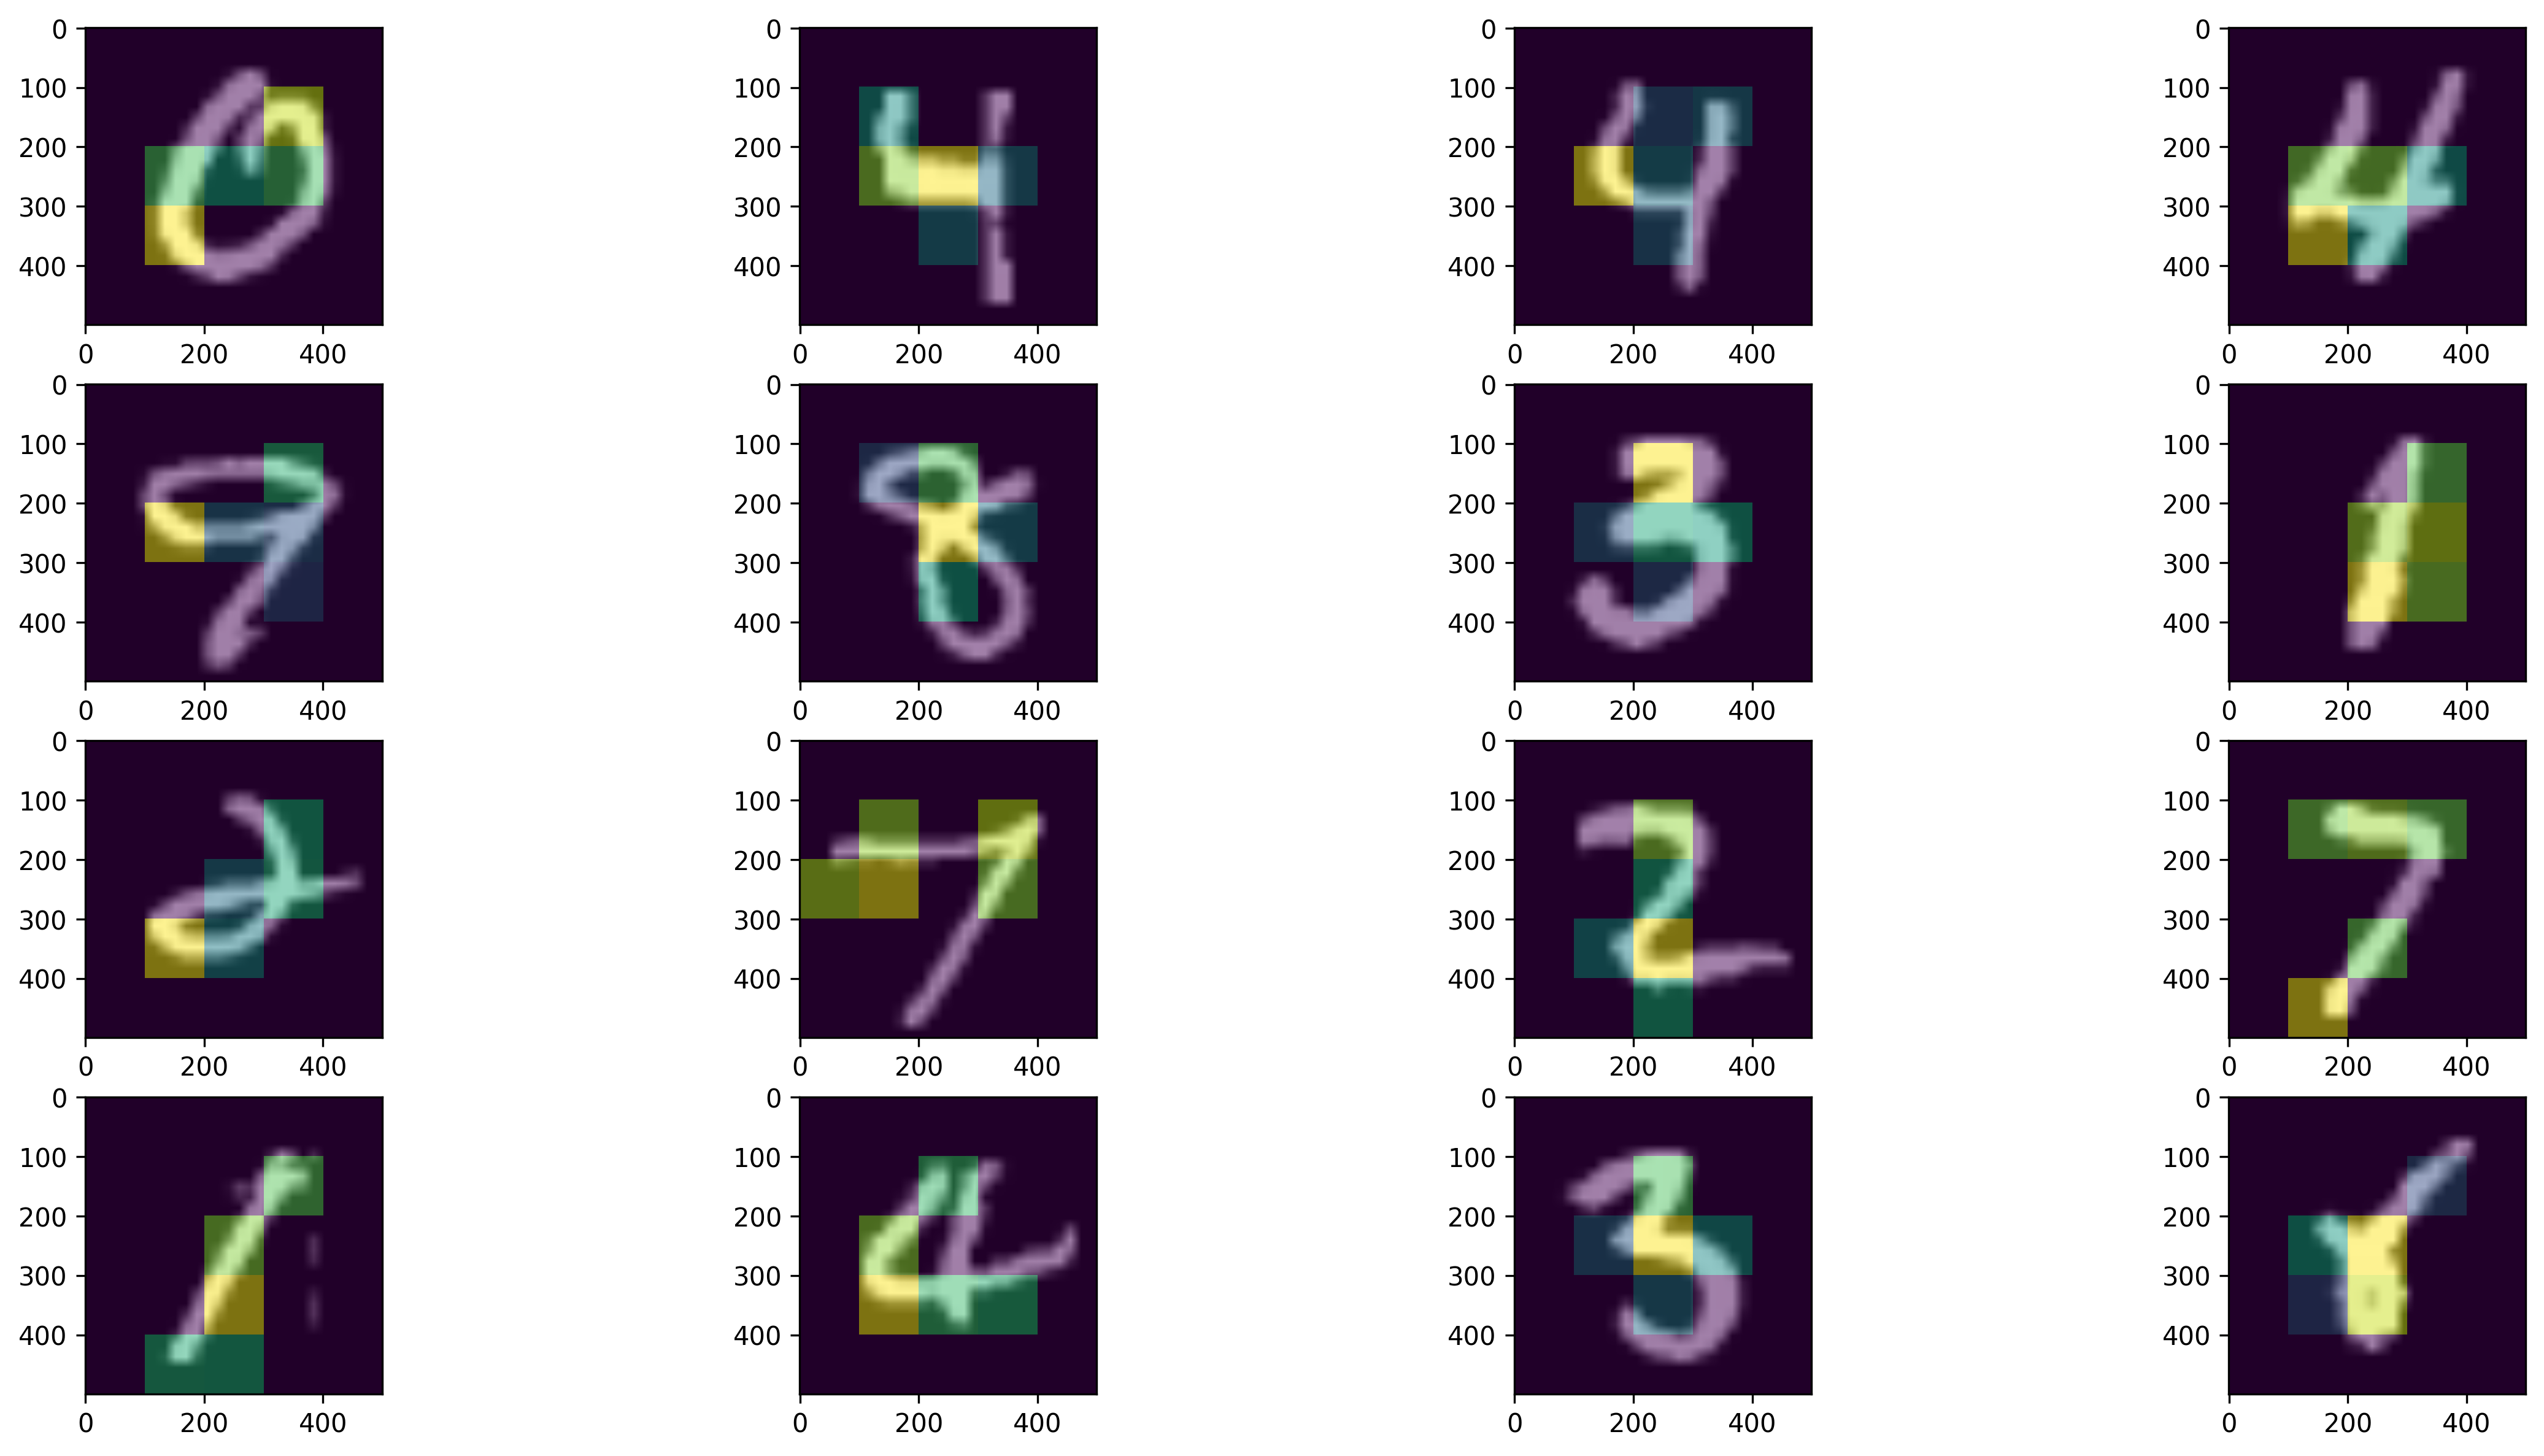

In [13]:
# Plot images and corresponding attention maps
n_row = int(math.sqrt(n_img_vis))
n_col = n_row

fig = plt.figure(dpi=300, figsize=(19.20,9.83))
for i, (img, attn) in enumerate(zip(images, attn_map)):
  img = img.numpy()
  img = (img - np.min(img))/np.ptp(img)
  img = np.transpose(img, (1, 2, 0))

  attn = attn.numpy()
  attn = (attn - np.min(attn)) / np.ptp(attn)
  attn = np.transpose(attn, (1, 2, 0))

  ax = fig.add_subplot(n_row, n_col, i+1)      
  ax.imshow(img.squeeze(), cmap='gray')
  ax.imshow(attn.squeeze(), alpha=0.5)

plt.show()